<a href="https://colab.research.google.com/github/haegomm/ai_practice/blob/master/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

##[MY CODE] Test data 준비하기
  학습 데이터셋과 테스트 데이터셋 구분하여 준비</br>
  테스트 데이터는 랜덤하게 섞을 필요가 없기 때문에 shuffle을 False로 지정

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) #[MY CODE] train=False 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False) #[MY CODE] shuffle=False 설정

60000
torch.Size([1, 28, 28]) 5


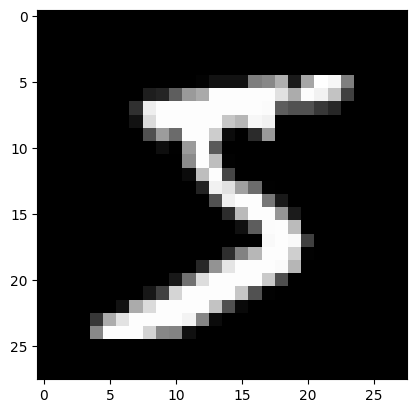

In [13]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [14]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


##[MY CODE] output dimension 수정

In [15]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim, num_classes):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, num_classes) # [MY CODE] output dimension 수정

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


model = Model(28 * 28 * 1, 1024, num_classes=10)

##[MY CODE] 모델 평가 함수 추가

In [16]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

##[MY CODE] 그래프 그리기 함수 추가

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

##[MY CODE] 분류를 위한 cross entropy loss 사용

In [18]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

criterion = nn.CrossEntropyLoss() # [MY CODE] 분류를 위한 cross entropy loss 사용
optimizer = SGD(model.parameters(), lr=lr)

##[LOG] 학습 과정에서의 Epoch별 손실값 출력

In [19]:
n_epochs = 100

train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
  total_loss = 0.
  correct_train = 0
  total_train = 0

  model.train() # 학습
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # 학습 정확도 계산
  train_accuracy = accuracy(model, trainloader)
  test_accuracy = accuracy(model, testloader)

  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

  print(f"Epoch {epoch:3d} | Loss: {total_loss:.4f} | "f"Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")

Epoch   0 | Loss: 528.9379 | Train Accuracy: 0.4668 | Test Accuracy: 0.4822
Epoch   1 | Loss: 506.7869 | Train Accuracy: 0.6009 | Test Accuracy: 0.6122
Epoch   2 | Loss: 481.9072 | Train Accuracy: 0.6560 | Test Accuracy: 0.6671
Epoch   3 | Loss: 451.9528 | Train Accuracy: 0.6906 | Test Accuracy: 0.7040
Epoch   4 | Loss: 416.3746 | Train Accuracy: 0.7082 | Test Accuracy: 0.7216
Epoch   5 | Loss: 376.7019 | Train Accuracy: 0.7350 | Test Accuracy: 0.7485
Epoch   6 | Loss: 336.0071 | Train Accuracy: 0.7592 | Test Accuracy: 0.7707
Epoch   7 | Loss: 297.8031 | Train Accuracy: 0.7817 | Test Accuracy: 0.7922
Epoch   8 | Loss: 264.4522 | Train Accuracy: 0.7964 | Test Accuracy: 0.8067
Epoch   9 | Loss: 236.8072 | Train Accuracy: 0.8101 | Test Accuracy: 0.8195
Epoch  10 | Loss: 214.1869 | Train Accuracy: 0.8204 | Test Accuracy: 0.8265
Epoch  11 | Loss: 195.9071 | Train Accuracy: 0.8276 | Test Accuracy: 0.8347
Epoch  12 | Loss: 180.9952 | Train Accuracy: 0.8358 | Test Accuracy: 0.8436
Epoch  13 | 

##[LOG] Epoch에 따른 train과 test data에 대한 모델 정확도 plot

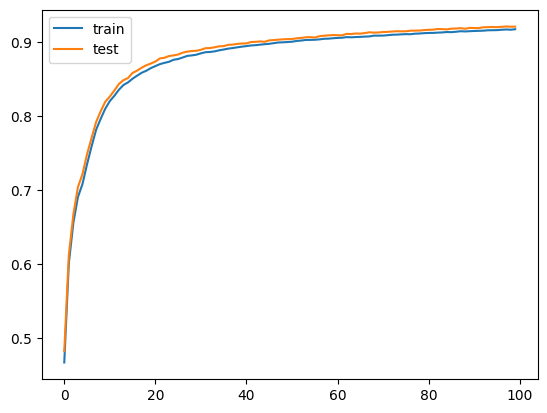

In [20]:
plot_acc(train_accuracies, test_accuracies)

In [21]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[ 0.8146, -4.0795,  0.4928,  4.5659, -5.9181,  5.5554, -2.6495, -0.3713,
          0.1767, -0.6096]], device='cuda:0', grad_fn=<AddmmBackward0>)
5


##[FEEDBACK] 초기화 궁금증
강의에서는 optimizer.zero_grad()로 optimizer를 초기화 했습니다. </br>
그런데 MNIST 과제 자료에서는 model을 초기화 하던데 어떤 걸 초기화해도 상관 없는 것일까요? </br>
실제로 model를 초기화해보기도 하고 optimizer을 초기화해보기도 했었는데 큰 차이는 보이지 않았습니다.
